<a href="https://colab.research.google.com/github/mens0n/hoon4IT/blob/main/Property_management_system_for_hotels_in_the_algarve_region.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving test2.csv to test2.csv


In [2]:
!ls

sample_data  test2.csv


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf

df = pd.read_csv("test2.csv")
df.head().T

,0,1,2,3,4
IsCanceled,0,0,0,0,0
LeadTime,342,737,7,13,14
ArrivalDateYear,2015,2015,2015,2015,2015
ArrivalDateMonth,July,July,July,July,July
ArrivalDateWeekNumber,27,27,27,27,27
ArrivalDateDayOfMonth,1,1,1,1,1
StaysInWeekendNights,0,0,0,0,0
StaysInWeekNights,0,0,1,1,2
Adults,2,2,1,1,2
Children,0,0,0,0,0


# 1.Business understanding
- 어떤 분야인가?: 숙박업(호텔)
- 호텔의 수익구조나 Business Logic은?: 예약을 받아서 checkin부터 checkout까지 서비스 제공(자원 할당)
- 어떻게 해야 수익이 많이 날까?: 가능한 모든 객실이 Full-Booking(자원이 남지 않게 해야함)
- 수익을 극대화 하려면?: 수요량을 예측하고, 예약 취소 확률을 이용해서 초과예약(Over-Booking)을 관리
- 그렇다면 데이터셋에서 분석해야 할 것은?: 예약 취소 확률 파악
- 예약 취소 확률을 파악하려면?: 예약 취소에 영향을 주는 요인을 찾아 경영에 반영할 수 있게 함
- 이와 유사한 분야는?: 비행기 좌석 예약, 극장 예약

# 2.Data Understanding
####Label
- IsCanceled: 예약 취소 여부, 해당 데이터셋의 Label 해당

####Feature
######날짜관련
- LeadTime: 예약 시점과 체크인 시점의 간격
- ArrivalDateYear: 예약한 년도
- ArrivalDateMonth: 예약한 월
- ArrivalDateWeekNumber: 예약한 주수(1년 = 52주)
- ArrivalDateDayOfMonth: 한 달 기준 몇 번째 일로 예약했는지
- StaysInWeekendNights: 주말 숙박 일수
- StaysInWeekNights: 주중 숙박 일수 ####

######인원 관련
- Adults: 예약인원 중 성인 인원수
- Children: 예약인원 중 청소년 인원수
- Babies: 예약인원 중 아기 인원수 ####

######식사, 국적 관련
- Meal: 식사를 같이 예약했는지, 했으면 어떤 식사인지
- Country: 예약자의 국적 ####

######재방문 관련
- IsRepeatedGuest: 재방문 고객 여부
- PreviousCancellations: 과거 취소이력 ####

######상품 관련
- ReservedRoomType: 고객이 예약한 방의 종류
- AssignedRoomType: 고객에게 배정된 방의 종류, ex) 고객이 A를 선택했는데 상황에 따라 B로 배정될 수도 있음
- BookingChanges: 예약 세부사항 변경횟수 ####
예약 취소 관련
- DepositType: 예약 취소시 환불범위
- DaysInWaitingList: waiting 발생시 고객이 기다린 시간 ####

######그 외
- ADR: 객단가, 이 값이 높을수록 영향력 있는(매출에 도움되는) 고객(VIP)
- RequiredCarParkingSpaces: 요구한 주차 대수
- TotalOfSpecialRequests: 예약시 특별한 요청을 한 횟수, ex) 생일 케익, 프로포즈용 꽃

## Data Handling

In [4]:
df

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0,212,2017,August,35,31,2,8,2,1,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,1,No Deposit,143,NULL,0,Transient,89.75,0,0,Check-Out,2017-09-10
40056,0,169,2017,August,35,30,2,9,2,0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250,NULL,0,Transient-Party,202.27,0,1,Check-Out,2017-09-10
40057,0,204,2017,August,35,29,4,10,2,0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250,NULL,0,Transient,153.57,0,3,Check-Out,2017-09-12
40058,0,211,2017,August,35,31,4,10,2,0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,40,NULL,0,Contract,112.80,0,1,Check-Out,2017-09-14


### 경우의 수 Column 처리
- 경우의 수를 숫자로 변환
- 컴퓨터는 학습을 할 때 데이터가 숫자여야 처리가 쉬움(경우의 수로 처리되는 알고리즘도 있음)
- ex) 식사 관련 Column 중 Mael: B, HB, FB인데, 숫자로 표현하면 처리가 더 용이
- 경우의 수 처리법: Apply Domain Knowledge, Frequency Encoding, Target Encoding, One-hot Encoding

#### Apply Domain Knowledge
- 도메인 지식을 적용하는 방법
- 가장 이상적이고 우선적으로 적용
- ex) 기준을 정했을 때 정도의 차이가 발생
- ex) 순서를 매기면 의미가 있다

In [5]:
set(df['Meal'])

{'BB       ', 'FB       ', 'HB       ', 'SC       ', 'Undefined'}

- 대상 column : Meal
- SC & Undefined : 식사 예약 안함
- BB : 조식 예약
- HB : 두끼 예약
- FB : 세끼 모두 예약


In [6]:
mapper = {'SC       ':0,
          'Undefined':0,
          'BB       ':1,
          'HB       ':2,
          'FB       ':3}
df['Day_Stay'] = df['Meal'].map(mapper)
df[['Meal','Day_Stay']].head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Meal,BB,BB,BB,BB,BB,BB,BB,FB,BB,HB,BB,HB,BB,HB,BB,BB,BB,BB,BB,BB
Day_Stay,1,1,1,1,1,1,1,3,1,2,1,2,1,2,1,1,1,1,1,1


내국인과 외국인 구별(내국인 = 포루투갈)

In [7]:
df['Foreigner'] = 1
df.loc[df['Country'] == 'PRT', 'Foreigner'] = 0
interested = ['Foreigner', 'Country']
df[interested].head()

,Foreigner,Country
0,0,PRT
1,0,PRT
2,1,GBR
3,1,GBR
4,1,GBR


#### Frequency Encoding
- 경우의 수를 빈도(%)로 변환, 각 경우의 수가 데이터셋에서 차지하는 비율 적용
- ex) 경우1의 비율 : 50% -> 0.5%, 경우2의 비율 : 30% -> 0.3%, 경우3의 비율 : 20% -> 0.2%로 변환

In [8]:
df['Country'].value_counts()

PRT    17630
GBR     6814
ESP     3957
IRL     2166
FRA     1611
       ...  
ZMB        1
LKA        1
MKD        1
CYM        1
MAC        1
Name: Country, Length: 125, dtype: int64

In [9]:
df['Country'].value_counts(normalize = True)

PRT    0.445247
GBR    0.172088
ESP    0.099934
IRL    0.054702
FRA    0.040686
         ...   
ZMB    0.000025
LKA    0.000025
MKD    0.000025
CYM    0.000025
MAC    0.000025
Name: Country, Length: 125, dtype: float64

대상 Column : Country
- PRT가 0.445(전체 Row 중 Country Column의 PRT데이터가 44.5%)
- 대략 50% 비율로 내국인과 외국인으로 구분됨

In [10]:
cr = pd.DataFrame(df['Country'].value_counts(normalize = True)).reset_index()
cr.columns = ['Country', 'Country_Ratio']
cr.head()

,Country,Country_Ratio
0,PRT,0.445247
1,GBR,0.172088
2,ESP,0.099934
3,IRL,0.054702
4,FRA,0.040686


In [11]:
df = pd.merge(df, cr)
df.head().T

,0,1,2,3,4
IsCanceled,0,0,0,0,1
LeadTime,342,737,0,9,85
ArrivalDateYear,2015,2015,2015,2015,2015
ArrivalDateMonth,July,July,July,July,July
ArrivalDateWeekNumber,27,27,27,27,27
ArrivalDateDayOfMonth,1,1,1,1,1
StaysInWeekendNights,0,0,0,0,0
StaysInWeekNights,0,0,2,2,3
Adults,2,2,2,2,2
Children,0,0,0,0,0


In [12]:
interested = ['Country', 'Country_Ratio']
df[interested].head()

,Country,Country_Ratio
0,PRT,0.445247
1,PRT,0.445247
2,PRT,0.445247
3,PRT,0.445247
4,PRT,0.445247


#### Target Encoding
- Label(Target) 정보(통계량)를 경우의 수(그룹) 별로 적용
- Label이 있어야만 가능
- 선입견과 고정관념이 들어감 -> 과적합 될 확률이 높아짐

In [13]:
import numpy as np
df.groupby('Country').agg({'IsCanceled':np.mean}).reset_index().sort_values(by='IsCanceled')
# Column(Country)의 경우의 수 별로 label(IsCanceled)이 얼만큼 섞여 있는지 통계량을 적용
# 빈도수가 낮은 경우의 수는 고정관념과 선입견이 발생
# 빈도수가 높은 일반화의 경우에는 필요에 따라 고정관념과 선입견이 필요함

,Country,IsCanceled
62,JOR,0.0
86,NPL,0.0
82,MYS,0.0
81,MWI,0.0
80,MUS,0.0
...,...,...
12,BHR,1.0
61,JEY,1.0
100,SEN,1.0
43,FJI,1.0


#### One-hot Encoding
- 경우의 수 별로 Column을 새로 만들어서 해당 경우의 수이면 1, 아니면 0
- 한 Row에서 한 Column만 Hot(1)함
- 일반적으로 도메인 지식을 적용할 수 없는 경우에 사용
- 경우의 수 Column 처리의 FM(field manual)


In [14]:
pd.get_dummies(df['Meal'])

,BB,FB,HB,SC,Undefined
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
39591,1,0,0,0,0
39592,1,0,0,0,0
39593,1,0,0,0,0
39594,1,0,0,0,0


##### 다중 공선성(multi-colinearity)
- 일부 Column이 다른 Column과 상관 정도가 높아 부정적 영향을 미치는 현상
- get_dummies()의 drop_first -> 모든 경우의 수를 다 사용하지 않고 일부를 뺌

In [15]:
pd.get_dummies(df['Country'])

,AGO,ALB,AND,ARE,ARG,ARM,AUS,AUT,AZE,BDI,BEL,BGR,BHR,BHS,BIH,BLR,BRA,BWA,CAF,CHE,CHL,CHN,CIV,CMR,CN,COL,COM,CPV,CRI,CUB,CYM,CYP,CZE,DEU,DJI,DNK,DOM,DZA,ECU,EGY,...,NOR,NPL,NZL,OMN,PAK,PER,PHL,PLW,POL,PRI,PRT,QAT,ROU,RUS,SAU,SEN,SGP,SMR,SRB,SUR,SVK,SVN,SWE,SYC,SYR,TGO,THA,TUN,TUR,TWN,UGA,UKR,URY,USA,UZB,VEN,VNM,ZAF,ZMB,ZWE
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39591,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
39592,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
39593,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
39594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [16]:
# One-hot Encoding 할 때, 경우의 수가 많은 경우 처리방안
sum(cr[:5]['Country_Ratio'])
# 방문 빈도가 높은 5개국 출신의 손님이 전체 손님 중 80%

0.8126578442266895

In [17]:
sum(cr[-100:]['Country_Ratio'])
# 방문 빈도가 낮은 100개국 출신의 손님이 전체 손님 중 2%

0.020507121931508172

In [18]:
top_5 = cr[:5]['Country'].values
top_5

array(['PRT', 'GBR', 'ESP', 'IRL', 'FRA'], dtype=object)

In [19]:
'GBR' in top_5

True

In [20]:
def country_hot(country):
  if country in top_5:
    return country
  else:
    return 'other'

sample = ['PRT', 'GBR', 'KOR', 'JPN']
for country in sample:
  print(country_hot(country))

PRT
GBR
other
other


In [21]:
df['Country_Simple'] = df['Country'].apply(lambda x:country_hot(x))
pd.get_dummies(df['Country_Simple'])

,ESP,FRA,GBR,IRL,PRT,other
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
39591,0,0,0,0,0,1
39592,0,0,0,0,0,1
39593,0,0,0,0,0,1
39594,0,0,0,0,0,1


한 줄짜리 lambda로 표현하는 과정

In [22]:
# 1. Country를 x로 표현
if x in top_5:
  return country
else:
  return 'other'

# 2. if~else 한 줄로 변경
# 조건(x in top_5)이 참이면 x를 결과로
# 조건이 거짓이면 'other'를 결과로 반환
x if x in top_5 else 'other'

# 3. apply(lambda) 적용
df['Country_Simple'] = df['Country'].apply(lambda x:x if x in top_5 else 'other')
pd.get_dummies(df['Country_Simple'])

SyntaxError: ignored

In [24]:
# 차를 가져오는 경우와 그렇지 않은 경우를 car_yes로 간단히 표현
df['car_yes'] = 0
df.loc[df['RequiredCarParkingSpaces'] > 0, 'car_yes'] = 1
set(df['car_yes'])

{0, 1}

In [25]:
# 고객이 예약한 상품과 고객에세 할당한 상품이 같을 때와 다를 때에 관한 정보를 추가
# set(df['ReservedRoomType'])
set(df['AssignedRoomType'])

{'A               ',
 'B               ',
 'C               ',
 'D               ',
 'E               ',
 'F               ',
 'G               ',
 'H               ',
 'I               ',
 'L               '}

In [26]:
# 뒤에 공백제거
df['ReservedRoomType'] = df['ReservedRoomType'].apply(lambda x:x[0])
df['AssignedRoomType'] = df['AssignedRoomType'].apply(lambda x:x[0])
set(df['ReservedRoomType'])

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'L'}

In [27]:
df['RA'] = df['ReservedRoomType'] + df['AssignedRoomType']

df['RA_Changed'] = df['RA'].apply(lambda x:0 if x[0] == x[1] else 1)
np.mean(df['RA_Changed'])
# 예약한 상품과 할당된 상품이 다른 경우는 대략 20%임

0.18958985756136984

In [28]:
df.head().T
set(df['ReservedRoomType'])

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'L'}

In [29]:
df.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'Day_Stay', 'Foreigner', 'Country_Ratio', 'Country_Simple', 'car_yes',
       'RA', 'RA_Changed'],
      dtype='object')

In [30]:
interested = ['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'Day_Stay', 'Foreigner', 'Country_Ratio', 'Country_Simple', 'car_yes',
       'RA', 'RA_Changed']
df[interested].to_csv('test2_modify.csv', index = False)

## 분류 모델
- 분류(Classification) : 주어진 데이터를 클래스 별로 구별하는 과정
- Label의 개수에 따라 분류할 수 있음
- 이진 분류(Binary)와 다중 분류(Multiclass)로 구분
- 알고리즘: Logistic Regression, 경사 하강법(Gradient Descent), 결정 트리(Decision Tree) 등

### EDA


In [31]:
df = pd.read_csv("test2_modify.csv")
df.describe().columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber',
       'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights',
       'Adults', 'Children', 'Babies', 'IsRepeatedGuest',
       'PreviousCancellations', 'PreviousBookingsNotCanceled',
       'BookingChanges', 'DaysInWaitingList', 'ADR',
       'RequiredCarParkingSpaces', 'TotalOfSpecialRequests', 'Day_Stay',
       'Foreigner', 'Country_Ratio', 'car_yes', 'RA_Changed'],
      dtype='object')

In [32]:
label = 'IsCanceled'
features = ['LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber',
       'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights',
       'Adults', 'Children', 'Babies', 'IsRepeatedGuest',
       'PreviousCancellations', 'PreviousBookingsNotCanceled',
       'BookingChanges', 'DaysInWaitingList', 'ADR',
       'TotalOfSpecialRequests', 'Day_Stay',
       'Foreigner', 'Country_Ratio', 'car_yes', 'RA_Changed']
X,y = df[features], df[label]

In [33]:
from sklearn.ensemble import RandomForestClassifier as rf

model = rf()
model.fit(X,y)
imp = pd.DataFrame()
imp['features'] = features
imp['importance'] = model.feature_importances_
imp.sort_values(by = 'importance', ascending = False).head(10)

,features,importance
0,LeadTime,0.186032
14,ADR,0.130131
2,ArrivalDateWeekNumber,0.082282
18,Country_Ratio,0.077456
3,ArrivalDateDayOfMonth,0.073942
19,car_yes,0.061534
5,StaysInWeekNights,0.052005
17,Foreigner,0.051255
20,RA_Changed,0.048353
15,TotalOfSpecialRequests,0.036425


In [37]:
import numpy as np
df.groupby('LeadTime').agg({label:np.mean}).reset_index()

,LeadTime,IsCanceled
0,0,0.048366
1,1,0.056172
2,2,0.092920
3,3,0.079487
4,4,0.063566
...,...,...
407,471,1.000000
408,532,0.000000
409,542,0.000000
410,709,0.000000


## Visualization

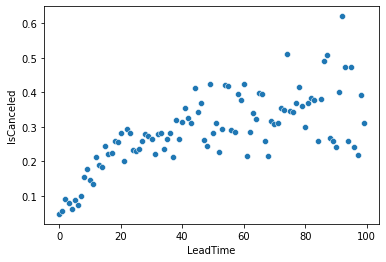

In [36]:
import seaborn as sns

tgt = df.groupby('LeadTime').agg({label:np.mean}).reset_index()

# 두 달 이전의 경우를 확인
tgt = tgt.loc[tgt['LeadTime'] < 100]
sns.scatterplot(data = tgt, x = 'LeadTime', y = 'IsCanceled')

# 대략 1주일 이전에 예약한 사람들은 예약 취소율 낮음
# 20~40일 전에 예약한 사람들은 보통 20~30% 정도 취소율을 보임
# 50일 이후부터는 취소율 다양함 -> LeadTime이 예약 취소율에 미치는 영향이 줄어든다고 해석할 수 있음
# 전체적으로 LeadTime이 늘어날수록 예약 취소율이 높아짐
# LeadTime이 적은 구간에서 선형성을 지님

In [38]:
hue = 'Foreigner'
df.groupby(['LeadTime', hue]).agg({label:np.mean})

IsCanceled
LeadTime Foreigner            
0        0            0.065923
         1            0.018261
1        0            0.075975
         1            0.021544
2        0            0.114530
...                        ...
471      0            1.000000
532      1            0.000000
542      1            0.000000
709      1            0.000000
737      0            0.000000

[786 rows x 1 columns]

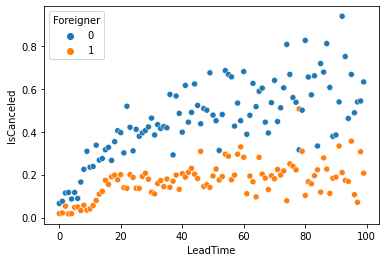

In [39]:
tgt = df.groupby(['LeadTime', hue]).agg({label:np.mean}).reset_index()
tgt = tgt.loc[tgt['LeadTime'] < 100]
sns.scatterplot(data = tgt, x = 'LeadTime', y = 'IsCanceled', hue = hue)

# 외국인은 내국인 대비 예약 취소율이 낮음

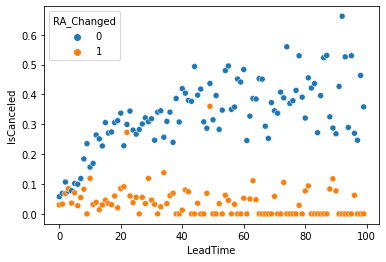

In [41]:
hue = 'RA_Changed'

tgt = df.groupby(['LeadTime', hue]).agg({label:np.mean}).reset_index()
tgt = tgt.loc[tgt['LeadTime'] < 100]
sns.scatterplot(data = tgt, x = 'LeadTime', y = 'IsCanceled', hue = hue)

# 고객이 예약한 상품을 변경해 주면 예약 취소율이 낮음

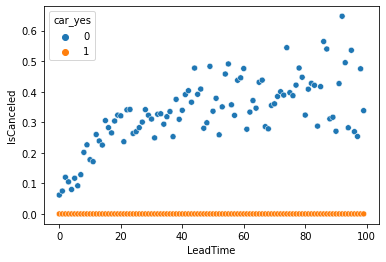

In [44]:
hue = 'car_yes'

tgt = df.groupby(['LeadTime', hue]).agg({label:np.mean}).reset_index()
tgt = tgt.loc[tgt['LeadTime'] < 100]
sns.scatterplot(data = tgt, x = 'LeadTime', y = 'IsCanceled', hue = hue)

# 차를 가져온다면 예약 취소율이 0에 가까워짐

In [46]:
# 어떤 경로로 예약해쓴지에 대한 Column을 기반으로 의미있는 문장 도출
set(df['MarketSegment'])

{'Complementary',
 'Corporate',
 'Direct',
 'Groups',
 'Offline TA/TO',
 'Online TA'}

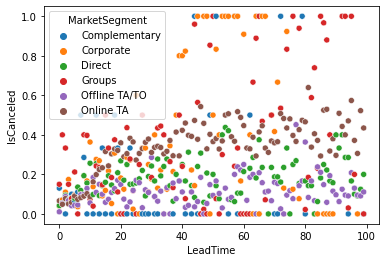

In [49]:
hue = 'MarketSegment'
tgt = df.groupby(['LeadTime', hue]).agg({label:np.mean}).reset_index()
tgt = tgt.loc[tgt['LeadTime'] < 100]
sns.scatterplot(data = tgt, x = 'LeadTime', y = 'IsCanceled', hue = hue)

## Data Preparation
- train, test split 작업 정도로만 진행

In [51]:
train, test = df[0::2], df[1::2]
train = train.reset_index()
test = test.reset_index()

X_train, y_train = train[features], train[label]
X_test, y_test = test[features], test[label]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19798, 21) (19798,)
(19798, 21) (19798,)


# 3.Modeling
- 현 데이터셋에서의 목적 : Tree 구조 알고리즘을 이용해서 내부가 어떻게 생겼는지 파악

## Tree구조 알고리즘


In [52]:
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.tree import export_graphviz as eg

model = dt(max_depth = 5)
model.fit(X_train, y_train)

eg(model, out_file = 'tree.txt', feature_names = features, class_names = ['Cancel_no', 'Cancel_yes'])

## 지니계수 계산방식
-지니계수 : 경제적 불평등의 정도를 계수화 한 것
- 불순도(불순한 정도) 확인
- 특정 사건이 일어날 확률을 yes_prob
- 특정 사건이 일어나지 않을 확률은 np_prob라고 했을때,

- yes_prob*(1-yes_prob)을 A라고 하고, 
- no_prob*(1-no_prob)을 B라고 하면
- A + B = 지니계수

In [53]:
size = 8815
yes_prob = 3726 / size
no_prob = 5089 / size
A = yes_prob * (1 - yes_prob)
B = no_prob * (1 - no_prob)
A+B

0.4880458945443443

In [54]:
yes_prob = 0.00
no_prob = 1
A = yes_prob * (1 - yes_prob)
B = no_prob * (1 - no_prob)
A+B

0.0

# 분류 모델 평가지표
- 회귀 문제에서는 숫자의 크기를 이용해 틀림의 정도를 나타낼 수 있음 -> 이걸 분류 문제에서는 사용 X
- 혼동행렬 개념 도입

In [55]:
model

DecisionTreeClassifier(max_depth=5)

In [57]:
model.predict(X_test)

array([0, 0, 1, ..., 0, 0, 0])

In [58]:
y_test

0        0
1        0
2        1
3        0
4        0
        ..
19793    0
19794    0
19795    0
19796    0
19797    0
Name: IsCanceled, Length: 19798, dtype: int64

In [59]:
for_plot = pd.DataFrame()
for_plot['predict'] = model.predict(X_test)
for_plot['actual'] = y_test
for_plot

,predict,actual
0,0,0
1,0,0
2,1,1
3,1,0
4,1,0
...,...,...
19793,0,0
19794,0,0
19795,0,0
19796,0,0


## 혼동행렬(Confusion Matrix)
- T: 맞춘 것, F: 틀린 것
- P: 예측결과 1, N: 예측결과 0
- TP: 예약 취소됨을 맞춘 경우
- TN: 예약 취소가 아님을 맞춘 경우
- FP: 예약 취소가 아닌데 예약 취소로 분류한 경우
- FN: 예약 취소인데 예약 취소 아님으로 분류한 경우

## 자주 사용하는 분류 문제의 평가지표


### 1.accuracy
- 모델이 입력된 데이터에 대해 얼마나 정확하게 예측하는지를 나타냄, 전체 중에 맞춘 비율
- 정확도 = 예측결과와 실제값이 맞은 건수 / 전체 데이터 수
- acc = (TP + TN) / (TP + TN + FP + FN)

### 2.precision
- 모델이 True라고 분류한 것 중에서 실제 True인 것의 비율
- prec = TP / (TP + FP)
- ex) 날씨 예측 모델이 맑다고 예측했는데, 실제 날씨가 맑았는지를 나타내는 지표

### 3.recall(재현율)
- 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율
- recall = TP / (TP + FN)
- ex) 실제 날씨가 맑은 날 중에서 모델이 맑다고 예측한 비율을 나타내는 지표
- sensitivity, hit rate

### 4.fall-out
- 실제 False인 데이터 중에서 모델이 True라고 예측한(잘못 예측) 비율
- fall = FP / (FP + TN)

### 언제 acc대신 prec, recall등이 고려될까?
-클래스 불균형(class imbalance issue)가 발생할 때 accuracy의 의미가 떨어짐
#### 화재 경보(불이 난 경우: 1, 안 난 경우: 0)
- FP는 불 났다고 판단했으나 불 안남(False Alarm)
- FN는 안났다고 판단했으나 불 남(Miss)
- 경중의 차이가 크다(FP는 틀려도 괜찮지만, FN은 큰일) -> FN에 중점을 둬야함

#### 스팸메일 분류(스팸인 경우:1, 아닌 경우:0)
- FP: 스팸이라고 판단, 스팸 아님
- FN: 스팸이 아니라고 판단, 스팸임
- -> FP에 중점을 둬야함

#### FP와 FN 해석
- 분야마다 어디에 무게를 둘 지 다름
- FP-FN 관계 Trade-Off

#### 게임 어뷰저 분류(어뷰저인 경우: 1, 아닌 경우: 0)
- FP: 어뷰저라고 판단했으나 어뷰저가 아님
- FN: 어뷰저가 아니라고 판단했는데 어뷰저임
- FP에 중점을 두면 선량한 유저의 반발이 심해지고, FN에 중점을 두면 어뷰저가 많아짐

In [61]:
from sklearn.metrics import confusion_matrix as cm

TN, FP, FN, TP = cm(for_plot['actual'], for_plot['predict']).ravel()
print(TN, FP, FN, TP)

13424 849 2490 3035


In [62]:
acc = (TP + TN) / (TP + TN + FN + FP)
prec = TP / (TP + FP)
recall = TP / (TP + FN)
print(acc, prec, recall)

0.831346600666734 0.7814109165808445 0.5493212669683258


## ROC_Curve
- 분류 모형 성능을 시각화하여 상호 비교할 수 있음
- 여러 임계값들을 기준으로 recall - fallout의 변화를 시각화한 것

In [64]:
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.ensemble import GradientBoostingClassifier as gb

model1, model2, model3 = dt(), rf(), gb()
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

model2.predict_proba(X_test)
# 0이라고 예측할건데, 확신하는 정도는 83%라는 의미

array([[0.83, 0.17],
       [0.77, 0.23],
       [0.28, 0.72],
       ...,
       [1.  , 0.  ],
       [0.87, 0.13],
       [0.77, 0.23]])

In [65]:
r1 = pd.DataFrame(model1.predict_proba(X_test), columns = ['negetive', 'positive'])
r2 = pd.DataFrame(model2.predict_proba(X_test), columns = ['negetive', 'positive'])
r3 = pd.DataFrame(model3.predict_proba(X_test), columns = ['negetive', 'positive'])

r1
# 과적합 느낌이 있음

,negetive,positive
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0
...,...,...
19793,1.0,0.0
19794,1.0,0.0
19795,1.0,0.0
19796,1.0,0.0


In [66]:
r2
# 100% 확신은 아님
# RandomForest는 투표로 결정(bagging)

,negetive,positive
0,0.83,0.17
1,0.77,0.23
2,0.28,0.72
3,0.42,0.58
4,0.63,0.37
...,...,...
19793,0.97,0.03
19794,0.97,0.03
19795,1.00,0.00
19796,0.87,0.13


In [67]:
r3

,negetive,positive
0,0.494244,0.505756
1,0.816796,0.183204
2,0.288396,0.711604
3,0.370010,0.629990
4,0.361432,0.638568
...,...,...
19793,0.605018,0.394982
19794,0.605018,0.394982
19795,0.551790,0.448210
19796,0.551790,0.448210


### Roc_Curve 예시


In [69]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
x1, y1, _ = roc_curve(y_test, r1['positive'])
print(x1)
print(y1)

[0.         0.10922721 0.1094374  0.10964759 0.10971765 0.11153927
 0.11195964 0.11223989 0.11350102 0.11364114 0.11399145 1.        ]
[0.         0.760181   0.76054299 0.76108597 0.76144796 0.76506787
 0.76506787 0.76524887 0.76579186 0.76597285 0.76651584 1.        ]


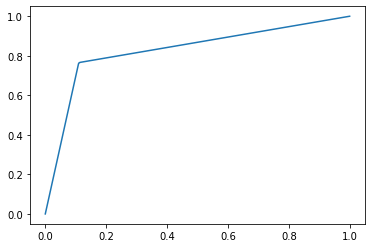

In [70]:
plt.plot(x1, y1, label = 'DecisionTree')

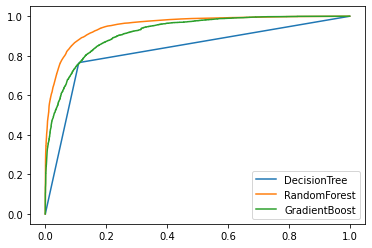

In [71]:
x2, y2, _ = roc_curve(y_test, r2['positive'])
x3, y3, _ = roc_curve(y_test, r3['positive'])
plt.plot(x1, y1, label='DecisionTree')
plt.plot(x2, y2, label='RandomForest')
plt.plot(x3, y3, label='GradientBoost')
plt.legend()

### Roc_Curve는 어떻게 그려질까?
- 확신의 정도와 실제 정답을 이용해 y축: recall, x축: fall-out 좌표로 이용
- recall: 실제 True인 것 중 맞춘 비율
- fall-out: 실제 False인 것 중 틀린 비율
- 전부 True라 예측하면? -> recall: 1.0, fallout: 1.0 -> (1, 1) 좌표
- 전부 False라 예측하면? -> recall: 0.0, fallout: 0.0 -> (0, 0) 좌표
- 판단 기준: 0~100%까지 조금씩 바꾸면서 그때마다 confusion-matrix 획득
- confusion-matrix 로부터 평가지표 값 산출
- ex) 판단 기준을 0, 10, 20, ... 100%으로 총 11번 다르게 한다면 -> confusion-matrix 11개 나올 것이고, 좌표 평면에 점을 11개 찍을 수 있음 -> 이 점들을 이어 그리면 ROC_Curve 완성

In [72]:
r2['actual'] = y_test
r2.loc[r2['actual'] == 1]

,negetive,positive,actual
2,0.28,0.72,1
8,0.34,0.66,1
9,0.64,0.36,1
10,0.36,0.64,1
14,0.85,0.15,1
...,...,...,...
19732,0.02,0.98,1
19733,0.02,0.98,1
19734,0.91,0.09,1
19738,0.15,0.85,1


In [75]:
threshold = 0.1 #판단 기준이 되는 수치, 기본값 : 0.5(50%)

r2['predict'] = 0

# 1이라고 확신의 정도가 threshold를 넘어가는 상황에 예측값을 1로
r2.loc[r2['positive'] > threshold, 'predict'] = 1
r2
# 판단 기준이 되는 수치에 따라 예측값이 달라짐
# 즉, 알고리즘 내에 확신의 정도는 달라지지 않지만
# 어느정도 이사의 확신이 있을 때 1이라고 할 것인지는 바꿀 수 있음

,negetive,positive,actual,predict
0,0.83,0.17,0,1
1,0.77,0.23,0,1
2,0.28,0.72,1,1
3,0.42,0.58,0,1
4,0.63,0.37,0,1
...,...,...,...,...
19793,0.97,0.03,0,0
19794,0.97,0.03,0,0
19795,1.00,0.00,0,0
19796,0.87,0.13,0,1


In [77]:
# r2를 Confusion matrix로 표현

r2['actual'] = y_test
threshold = 0.1 # 0-1 사이 변화에 따라 FN-FP 조율
r2['predict'] = 0
r2.loc[r2['positive'] > threshold, 'predict'] = 1

TN, FP, FN, TP = cm(r2['actual'], r2['predict']).ravel()
acc = (TP + TN) / (TP + TN + FP + FN)
prec = TP / (TP + FP)
recall = TP / (TP + FN)
fall = FP / (FP + TN)

print(FP, FN)
print(acc, prec, recall)

# threshold: 0.5 -> FP: 794, FN:1218
# threshold: 0.9 -> FP: 31, FN:3633
# threshold: 0.1 -> FP: 4504, FN:146

4531 151
0.7635114658046267 0.5425542655224634 0.9726696832579186


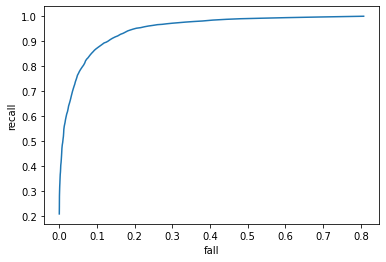

In [79]:
import seaborn as sns

data_points = 100
score_list = []

for i in range(data_points):
    threshold = i / data_points
    r2['predict'] = 0
    r2.loc[r2['positive'] > threshold, 'predict'] = 1
    TN, FP, FN, TP = cm(r2['actual'], r2['predict']).ravel()
    
    prec = TP / (TP + FP)
    recall = TP / (TP + FN)
    fall = FP / (FP + TN)
    
    scores = {'precision': prec, 'recall': recall, 'fall':fall}
    score_list.append(scores)
    
curve_df = pd.DataFrame(score_list)
sns.lineplot(data=curve_df, x='fall', y='recall')

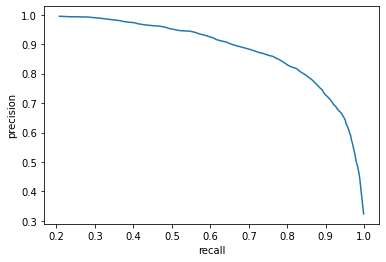

In [80]:
# PR_Curve
sns.lineplot(data=curve_df, x='recall', y='precision')

## 초매개변수 조정(Hyperparameter-Tuning)
- Hyperparameter:모델이 학습할 수 없어서 사용자가 지정해야하는 parameter
- 알고리즘의 옵션을 조정해 성능을 튜닝하는 방법
- 최적의 옵션값을 찾아 알고리즘 성능을 극대화시키는 방법


In [81]:
model = rf()
model.fit(X_train, y_train)
for_plot = pd.DataFrame()
for_plot['predict'] = model.predict(X_test)
for_plot['actual'] = y_test

TN, FP, FN, TP = cm(for_plot['actual'], for_plot['predict']).ravel()
recall = TP / (TP + FN)
print(recall)

0.7813574660633484


In [82]:
model = rf(max_depth=10, max_features=0.9)
model.fit(X_train, y_train)

for_plot = pd.DataFrame()
for_plot['predict'] = model.predict(X_test)
for_plot['actual'] = y_test

TN, FP, FN, TP = cm(for_plot['actual'], for_plot['predict']).ravel()
recall = TP / (TP + FN)
print(recall)

# 옵션1의 최적값을 찾은 다음 옵션2의 최적값을 찾는다? -> X
# 여러 옵션의 최적값을 찾을 땐 매개변수를 동시에 바꿔가면서 최적의 값을 찾아야 함

0.7058823529411765


In [83]:
def scorer(model):
    model.fit(X_train, y_train)
    for_plot = pd.DataFrame()
    for_plot['predict'] = model.predict(X_test)
    for_plot['actual'] = y_test
    TN, FP, FN, TP = cm(for_plot['actual'], for_plot['predict']).ravel()
    recall = TP / (TP + FN)
    return recall

model = rf(max_depth=7, max_features=0.6)
scorer(model)

0.6604524886877828

### Hyperparameter-Tuning 접근법
- Grid-Search : 격자 모양으로 찾기
- Random-Search : 무작위 조합으로 찾기(나름의 시스템이 있음)
- Optimizer : 수학을 기반으로 함수의 정의역이 옵션, 치역이 평가지표


#### Grid-Search
- 장점: 거의 모든 영역을 다 찾아볼 수 있음
- 단점: 거의 모든 조합을 시도하기 때문에 시간이 오래 걸림(언제 끝날지 모름 -> 옵션 값에 따라서 학습속도가 달라질 수 있음)

In [84]:
md_ls = [3, 5, 7, 9, 11, 13, 15, 17]
mf_ls = [0.1, 0.3, 0.5, 0.7, 0.9]
all_scores = []

for md in md_ls:
    for mf in mf_ls:
        model = rf(max_depth=md, max_features=mf, n_jobs=-1) # n_jobs
        all_scores.append({'recall': scorer(model), 'md': md, 'mf': mf})

hyper_df = pd.DataFrame(all_scores)
hyper_df.sort_values(by='recall', ascending=False)

,recall,md,mf
38,0.791493,17,0.7
37,0.789683,17,0.5
39,0.788778,17,0.9
34,0.776652,15,0.9
36,0.773032,17,0.3
32,0.769593,15,0.5
33,0.768869,15,0.7
31,0.750226,15,0.3
29,0.745158,13,0.9
28,0.743167,13,0.7


#### Random-Search
- 정한 시간 동안에 조합을 무작위로 만들어 찾아나감
- 처음에는 넓은 영역을 대상으로 찾고, 이후에는 찾는 범위를 점차 줄여나감
- 장점: Tuning에 걸리는 시간을 제어할 수 있음
- 단점: 최적의 조합을 찾는데 걸리는 시간이 부족할 수도 있음


In [85]:
import time

target_time = 5
t0 = time.time()

while True:
    t1 = time.time() - t0
    if t1 > target_time:
        break
    
print('반복 끝')

반복 끝


In [86]:
from random import randint

randint(1, 999) / 1000

0.41

In [87]:
import time

target_time = 120
t0 = time.time()

while True:
    t1 = time.time() - t0
    if t1 > target_time:
        break
        
    md = randint(3, 20)
    mf = randint(1, 999) / 1000
    model = rf(max_depth=md, max_features=mf, n_jobs=-1) # n_jobs
    all_scores.append({'recall': scorer(model), 'md': md, 'mf': mf})

hyper_df = pd.DataFrame(all_scores)
hyper_df.sort_values(by='recall', ascending=False)

,recall,md,mf
83,0.797828,20,0.641
84,0.797466,18,0.831
78,0.795837,20,0.397
42,0.795837,19,0.754
67,0.794208,18,0.636
...,...,...,...
15,0.565792,9,0.100
47,0.554389,8,0.124
10,0.513665,7,0.100
5,0.330317,5,0.100


In [88]:
hyper_df.sort_values(by='recall', ascending=False).head(20).describe()

,recall,md,mf
count,20.000000,20.000000,20.000000
mean,0.786308,17.200000,0.613750
std,0.009431,1.542384,0.200963
min,0.768869,15.000000,0.300000
25%,0.777602,16.000000,0.431000
50%,0.789412,17.000000,0.638500
75%,0.793122,18.000000,0.773250
max,0.797828,20.000000,0.920000


In [89]:
import time

target_time = 120
t0 = time.time()

while True:
    t1 = time.time() - t0
    if t1 > target_time:
        break
        
    md = randint(18, 30)
    mf = randint(656, 976) / 1000
    model = rf(max_depth=md, max_features=mf, n_jobs=-1) # n_jobs
    all_scores.append({'recall': scorer(model), 'md': md, 'mf': mf})

hyper_df = pd.DataFrame(all_scores)
hyper_df.sort_values(by='recall', ascending=False)

,recall,md,mf
102,0.801991,24,0.775
116,0.801810,19,0.676
118,0.800543,25,0.668
110,0.800181,23,0.892
96,0.799457,26,0.703
...,...,...,...
15,0.565792,9,0.100
47,0.554389,8,0.124
10,0.513665,7,0.100
5,0.330317,5,0.100
